Requiere los siguientes archivos de texto en el directorio:
imdb_small.csv ,
wiki-news-300d-1M.vec

In [2]:
#Módulos para implementar el algoritmo de clasificación / álgebra lineal.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#Modulos para pre-procesar las reviews. (Es decir, eliminar puntuación / Stop Words / Mayúsculas)
import nltk
from nltk.tokenize import punkt
from nltk.corpus import stopwords
nltk.download('stopwords')

#Módulo para nada
import fasttext

#Módulo para leer archivos
import io



In [11]:
#Leo la data
df = pd.read_csv(r"C:\Users\Guest123\Desktop\imdb_small.csv")

print(df.shape)

print("Cantidad de documentos: {}".format(df.shape[0]))

df.head(5)


(12500, 5)
Cantidad de documentos: 12500


,Unnamed: 0,type,review,label,file
0,19631,test,This movie is my families favorite Christmas m...,pos,5169_10.txt
1,32878,train,"Spoiler below, but read on or you'll never kno...",neg,5841_1.txt
2,28509,train,"One of the worst romantic comedies (nay, worst...",neg,1909_1.txt
3,32451,train,"An actor asks, ""What's my motivation?,"" to und...",neg,5457_1.txt
4,45002,train,Whether this movie is propaganda or not (I fir...,pos,5502_10.txt


In [13]:
text_train = df[df.type == 'train']["review"]
label_train = df[df.type == 'train']["label"]

text_test = df[df.type == 'test']["review"]
label_test = df[df.type == 'test']["label"]

print("Cantidad de instancias de entrenamiento = {}".format(len(text_train)))
print("Cantidad de instancias de test = {}".format(len(text_test)))

Cantidad de instancias de entrenamiento = 6225
Cantidad de instancias de test = 6275


In [14]:
#print("Class balance : {} pos {} neg".format(
    (label_train == 'pos').sum() / label_train.shape[0], 
    (label_train == 'neg').sum() / label_train.shape[0]
))

Class balance : 0.49493975903614457 pos 0.5050602409638554 neg


In [107]:
#Input : archivo de texto en donde c/línea contiene una palabra junto a su word embedding. 
#Los descargué de la página de FastText (Librería de Facebook AI Research)
#Output: data : un diccionario de palabras -> embeddings.
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float,tokens[1:])))
    return data    
    
data = load_vectors('wiki-news-300d-1M.vec')

#Cantidad de dimensiones en la que se van a representar los embeddings
vocabulary_size = data.get(list(data.keys())[0]).shape[0]

#El vocabulario. (Es decir, la lista de palabras que conocemos)
vocabulary = data.keys()

#Cantidad de datos de entrenamiento. (# de reviews)
num_training_examples = len(text_train.values)

#Inicializamos la matriz que va a almacenar los datos de entrenamiento ya transformados en sus embeddings correspondientes.
training_matrix = np.zeros((num_training_examples, vocabulary_size))


#Recorremos las reviews.
for i in range(num_training_examples): 
    
    #Se inicializa un vector de ceros para representar el embedding asociado a el i-ésimo review
    embedding = np.zeros(vocabulary_size) 
    
    #Preprocesamiento de la data utilizando los módulos mencionados anteriormente. 
    
    #Se elimina puntuación.
    token_list2 = list(filter(lambda token : punkt.PunktToken(token).is_non_punct,text_train.values[i].split()))
    #Se transforman las palabras en minúscula
    token_list3 = [word.lower() for word in token_list2]
    #Se eliminan stop-words. 
    token_list4 = list(filter(lambda token: token not in stopwords.words("english"),token_list3))
    
    #Recorremos las palabras de la review i-ésima.
    for word in token_list4: 
        if word in vocabulary: 
            embedding = embedding + data.get(word)
    embedding = embedding / len(token_list4)
    
    #Almacenamos el embedding asociado a la i-ésima review en la fila i-ésima de la matriz de entrenamiento.
    training_matrix[i] = embedding

#Se actualizan las etiquetas de entrenamiento a un vector de booleanos.
y_train = (label_train == 'pos').values


#Se repite exactamente el mismo proceso para los datos de entrenamiento. (Omito los comentarios por ser análogo)
num_testing_examples = len(text_test.values)

testing_matrix = np.zeros((num_testing_examples, vocabulary_size))

for i in range(num_testing_examples):
    
    token_list2 = list(filter(lambda token : punkt.PunktToken(token).is_non_punct,text_test.values[i].split()))
    token_list3 = [word.lower() for word in token_list2]
    token_list4 = list(filter(lambda token: token not in stopwords.words("english"),token_list3))
    
    embedding = np.zeros(vocabulary_size) 
    for word in token_list4: 
        if word in vocabulary: 
            embedding = embedding + data.get(word) 
    embedding = embedding / len(token_list4)
    
    testing_matrix[i] = embedding

label_test = df[df.type == 'test']["label"]
y_test = (label_test == 'pos').values


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guest123\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.7493227091633466


In [ ]:
#Ajustamos el clasificador a nuestra data de entreamiento y realizamos las predicciones sobre los datos de test.

clf = KNeighborsClassifier(n_neighbors=36)

clf.fit(training_matrix, y_train)

y_pred = clf.predict(testing_matrix)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(acc))

Text(0, 0.5, 'Mean Error')

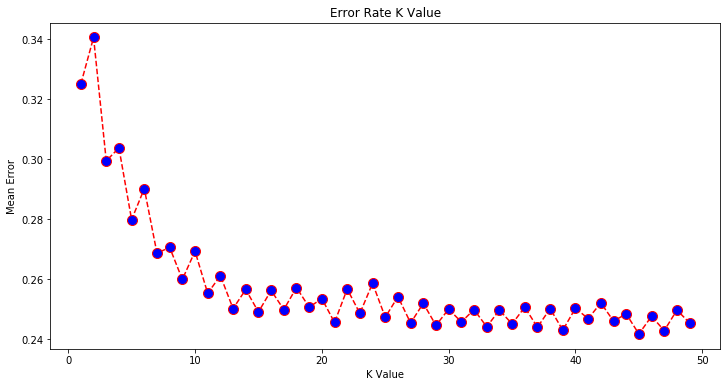

In [108]:
#Probamos distintos valores del hiperparámetro K.

error = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(training_matrix, y_train)
    y_pred = knn.predict(testing_matrix)
    error.append(np.mean(y_pred != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 50), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [112]:
print("Accuracy máxima: {}".format(1-min(error)))
print("Se alcanza con k = {}".format(error.index(min(error))+1))

Accuracy máxima: 0.7582470119521912
Se alcanza con k = 45
